Title
---

# Load Twitter Data

Let's load the last 10 days of Wordles

In [54]:
!rm -rf tweets/ # Remove tweets directory if it exists
!cp -a "/content/drive/MyDrive/Data+ Training/🎓 Capstone/Wordle_tweets/" /content/tweets/

In [55]:
# Split Large Files

!cp "/content/drive/MyDrive/Data+ Training/🎓 Capstone/json-split.py" /content/
!python json-split.py tweets/252.json
!python json-split.py tweets/253.json

cp: cannot stat '/content/drive/MyDrive/Data+ Training/🎓 Capstone/json.split.py': No such file or directory


# Set up Spark

In [56]:
!pip install -q pyspark
!pip install -q py4j
!pip install -q findspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless &> /dev/null

In [57]:
import findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
findspark.init()

In [58]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Wordle Tweet Analysis") \
    .getOrCreate()

sc = spark.sparkContext.getOrCreate()
sc

<SparkContext master=local[*] appName=Wordle Tweet Analysis>

In [59]:
from pyspark import SQLContext

sqlContext = SQLContext(sc)

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


# Extract data from JSON to Spark DF

In [99]:
dataframes = {
    '250': sqlContext.read.json("tweets/250.json"),
    '251': sqlContext.read.json("tweets/251.json"),
    '252_0': sqlContext.read.json("tweets/252_0.json"),
    '252_1': sqlContext.read.json("tweets/252_1.json"),
    '252_2': sqlContext.read.json("tweets/252_2.json"),
    '253_0': sqlContext.read.json("tweets/253_0.json"),
    '253_1': sqlContext.read.json("tweets/253_1.json"),
    '253_2': sqlContext.read.json("tweets/253_2.json"),
    '253_3': sqlContext.read.json("tweets/253_3.json"),
    '253_4': sqlContext.read.json("tweets/253_4.json"),
    '253_5': sqlContext.read.json("tweets/253_5.json"),
    '253_6': sqlContext.read.json("tweets/253_6.json"),
    '253_7': sqlContext.read.json("tweets/253_7.json"),
    '253_8': sqlContext.read.json("tweets/253_8.json"),
    '253_9': sqlContext.read.json("tweets/253_9.json"),
}

# Transform

In [100]:
from dateutil.parser import parse
from pyspark.sql.functions import lit, udf

def transform_df(df, wordle_no):

    parse_date = udf(lambda x: parse(x).date().isoformat())
    parse_hour = udf(lambda x: parse(x).hour)

    # Create column with isoformatted date
    return (df.withColumn("date_tweeted", parse_date('created_at'))
            .withColumn("hour_tweeted", parse_hour('created_at'))
            .withColumn("wordle", lit(wordle_no))
            .withColumn("engagement", df['favorite_count'] + df['retweet_count'])
            )

In [101]:
# Transform the dataframes and select only relevant columns for analysis
for wordle, dataframe in dataframes.items():
    dataframes[wordle] = (transform_df(dataframe, int(wordle.split('_')[0]))
        .select("wordle", "date_tweeted", "hour_tweeted", "text", "engagement", 
                "favorite_count", "retweet_count", "lang")
    )

## Union all dataframes

In [102]:
df = sqlContext.createDataFrame(sc.emptyRDD(), dataframes['250'].schema)
for dataframe in dataframes.values():
    df = df.unionByName(dataframe, allowMissingColumns=True)
df.persist()

DataFrame[wordle: int, date_tweeted: string, hour_tweeted: string, text: string, engagement: bigint, favorite_count: bigint, retweet_count: bigint, lang: string]

In [103]:
df.explain()

== Physical Plan ==
InMemoryTableScan [wordle#56074, date_tweeted#56075, hour_tweeted#56076, text#56077, engagement#56078L, favorite_count#56079L, retweet_count#56080L, lang#56081]
   +- InMemoryRelation [wordle#56074, date_tweeted#56075, hour_tweeted#56076, text#56077, engagement#56078L, favorite_count#56079L, retweet_count#56080L, lang#56081], StorageLevel(disk, memory, deserialized, 1 replicas)
         +- Union
            :- *(1) Scan ExistingRDD[wordle#56074,date_tweeted#56075,hour_tweeted#56076,text#56077,engagement#56078L,favorite_count#56079L,retweet_count#56080L,lang#56081]
            :- *(2) Project [250 AS wordle#53981, pythonUDF0#56210 AS date_tweeted#53915, pythonUDF1#56211 AS hour_tweeted#53948, text#52943, (favorite_count#52921L + retweet_count#52939L) AS engagement#54015L, favorite_count#52921L, retweet_count#52939L, lang#52932]
            :  +- BatchEvalPython [<lambda>(created_at#52918), <lambda>(created_at#52918)], [pythonUDF0#56210, pythonUDF1#56211]
            

# Load to Pandas

In [116]:
grouped_df = df.orderBy("date_tweeted","hour_tweeted").groupby("wordle", "date_tweeted","hour_tweeted")

time_df = grouped_df.count().toPandas()
time_df["hour_tweeted"] = time_df["hour_tweeted"].apply(lambda x: int(x))

engagement_df = grouped_df.sum("engagement").toPandas().rename(columns={'sum(engagement)':'total_engagement'})
engagement_df["hour_tweeted"] = engagement_df["hour_tweeted"].apply(lambda x: int(x))

retweet_df = grouped_df.sum("retweet_count").toPandas().rename(columns={'sum(retweet_count)': 'total_retweets'})
retweet_df["hour_tweeted"] = retweet_df["hour_tweeted"].apply(lambda x: int(x))

favorite_df = grouped_df.sum("favorite_count").orderBy("date_tweeted","hour_tweeted").toPandas().rename(columns={'sum(favorite_count)': 'total_favorites'})
favorite_df["hour_tweeted"] = favorite_df["hour_tweeted"].apply(lambda x: int(x))

In [132]:
import pandas as pd
# Combine date_tweeted with hour_tweeted
time_df["time"] = pd.to_datetime(time_df["date_tweeted"], infer_datetime_format=True) + pd.to_timedelta(time_df["hour_tweeted"], unit='h')
engagement_df["time"] = pd.to_datetime(engagement_df["date_tweeted"], infer_datetime_format=True) + pd.to_timedelta(time_df["hour_tweeted"], unit='h')
retweet_df["time"] = pd.to_datetime(retweet_df["date_tweeted"], infer_datetime_format=True) + pd.to_timedelta(time_df["hour_tweeted"], unit='h')
favorite_df["time"] = pd.to_datetime(favorite_df["date_tweeted"], infer_datetime_format=True) + pd.to_timedelta(time_df["hour_tweeted"], unit='h')

In [133]:
engagement_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 540 entries, 0 to 539
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   wordle            540 non-null    int32         
 1   date_tweeted      540 non-null    object        
 2   hour_tweeted      540 non-null    int64         
 3   total_engagement  540 non-null    int64         
 4   time              540 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 19.1+ KB


In [134]:
time_df

,time,wordle,date_tweeted,hour_tweeted,count
0,2022-03-01 06:00:00,250,2022-03-01,6,1
1,2022-03-05 14:00:00,250,2022-03-05,14,1
2,2022-03-02 15:00:00,250,2022-03-02,15,1
3,2022-02-28 19:00:00,250,2022-02-28,19,1
4,2022-03-02 23:00:00,250,2022-03-02,23,1
...,...,...,...,...,...
535,2022-02-26 20:00:00,253,2022-02-26,20,2270
536,2022-02-26 23:00:00,253,2022-02-26,23,5156
537,2022-02-26 21:00:00,253,2022-02-26,21,2703
538,2022-02-26 19:00:00,253,2022-02-26,19,1199


# Visualize

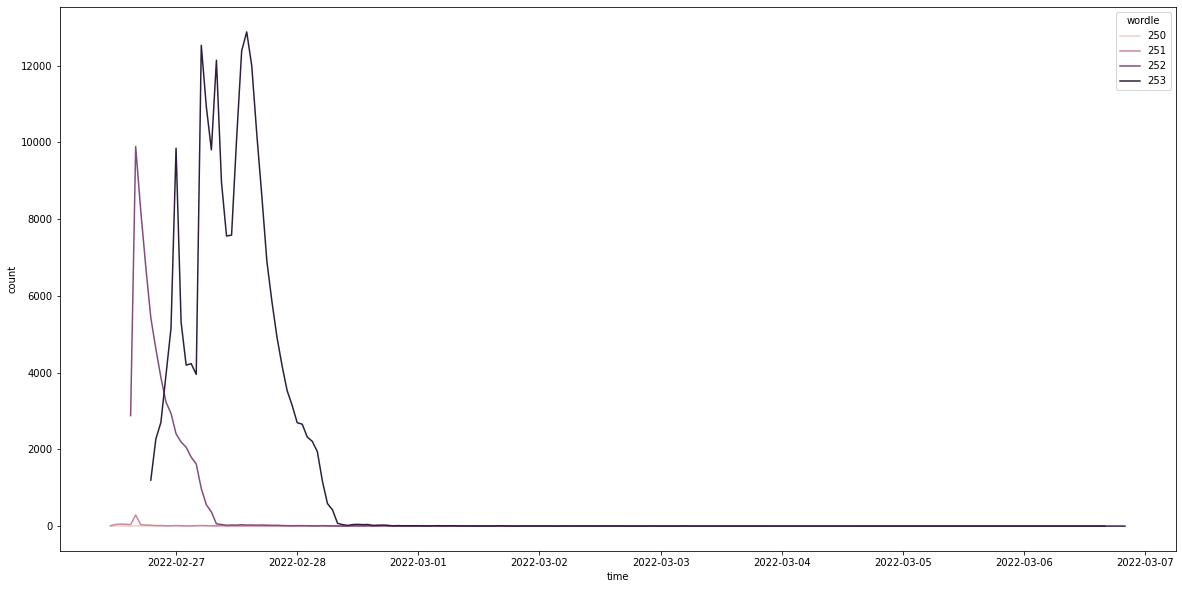

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(20,10))

# Title
# Font size
# Color scheme

sns.lineplot(
    data=time_df,
    x="time",
    y="count", 
    hue="wordle",
    ax=ax,
);

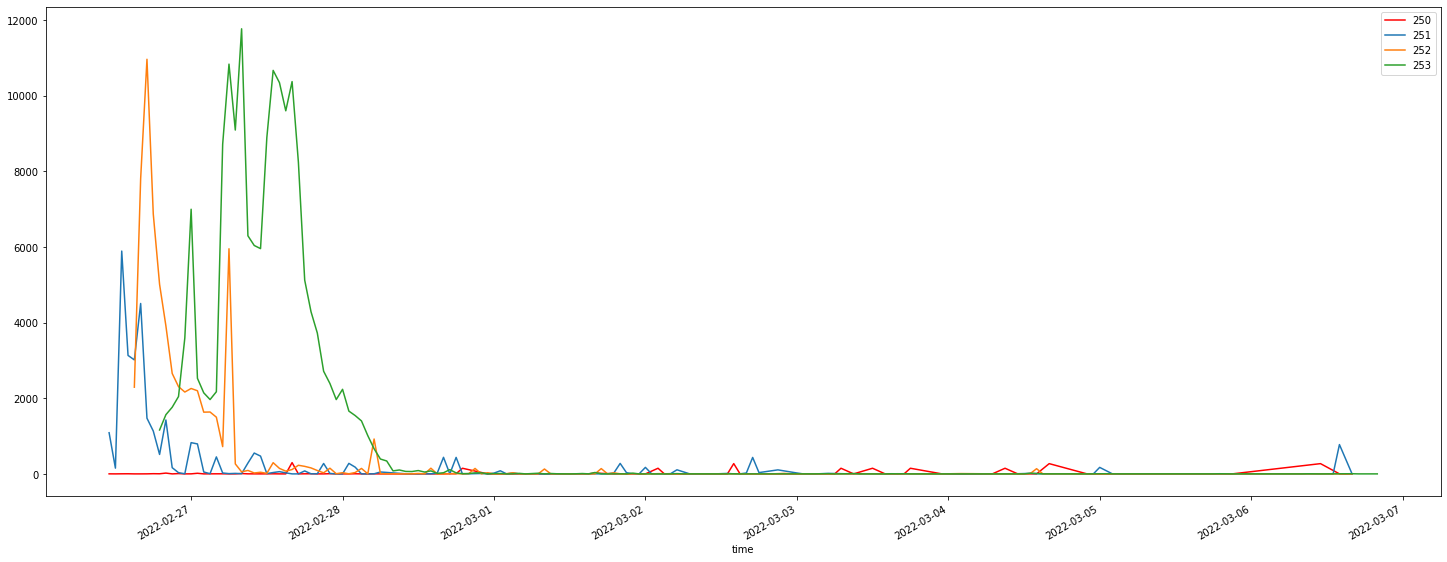

In [138]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,10))

# time_df.groupby(by=['date_tweeted', 'hour_tweeted']).sum('count').plot(kind='line', y='count', ax=ax);
engagement_df[engagement_df["wordle"]==250].groupby(by='time').sum('total_engagement').plot(
    kind='line', y='total_engagement', ax=ax, label="250", color='r')
engagement_df[engagement_df["wordle"]==251].groupby(by='time').sum('total_engagement').plot(
    kind='line', y='total_engagement', ax=ax, label="251")
engagement_df[engagement_df["wordle"]==252].groupby(by='time').sum('total_engagement').plot(
    kind='line', y='total_engagement', ax=ax, label="252")
engagement_df[engagement_df["wordle"]==253].groupby(by='time').sum('total_engagement').plot(
    kind='line', y='total_engagement', ax=ax, label="253");

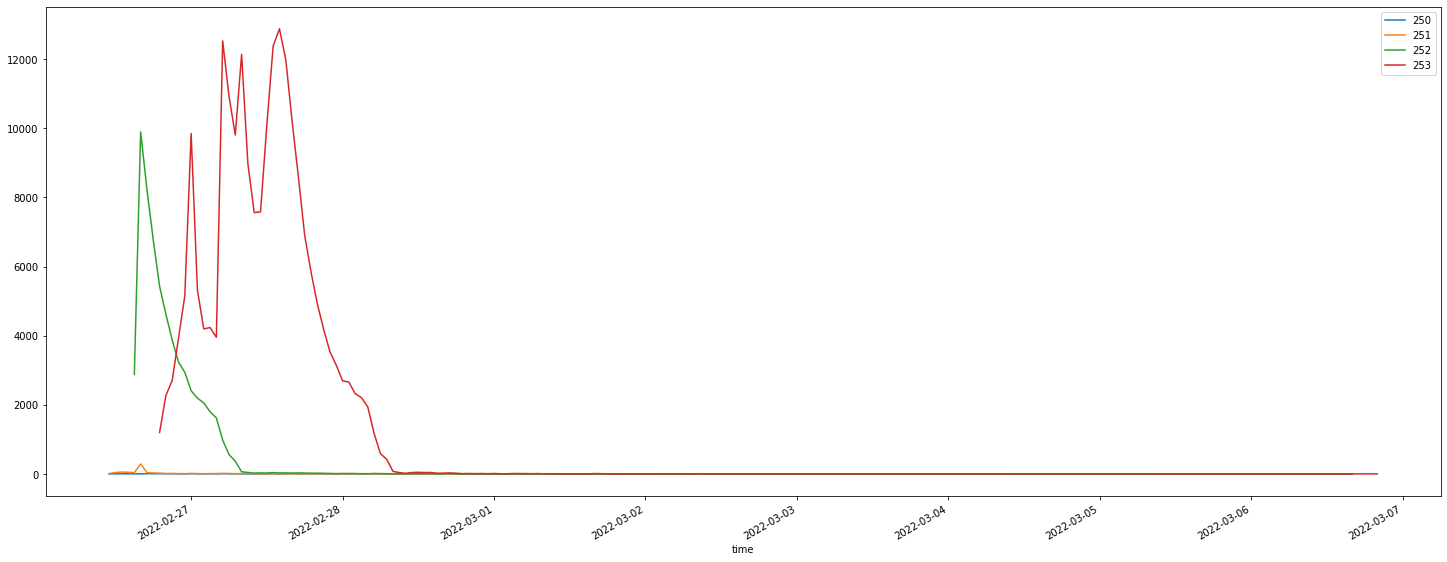

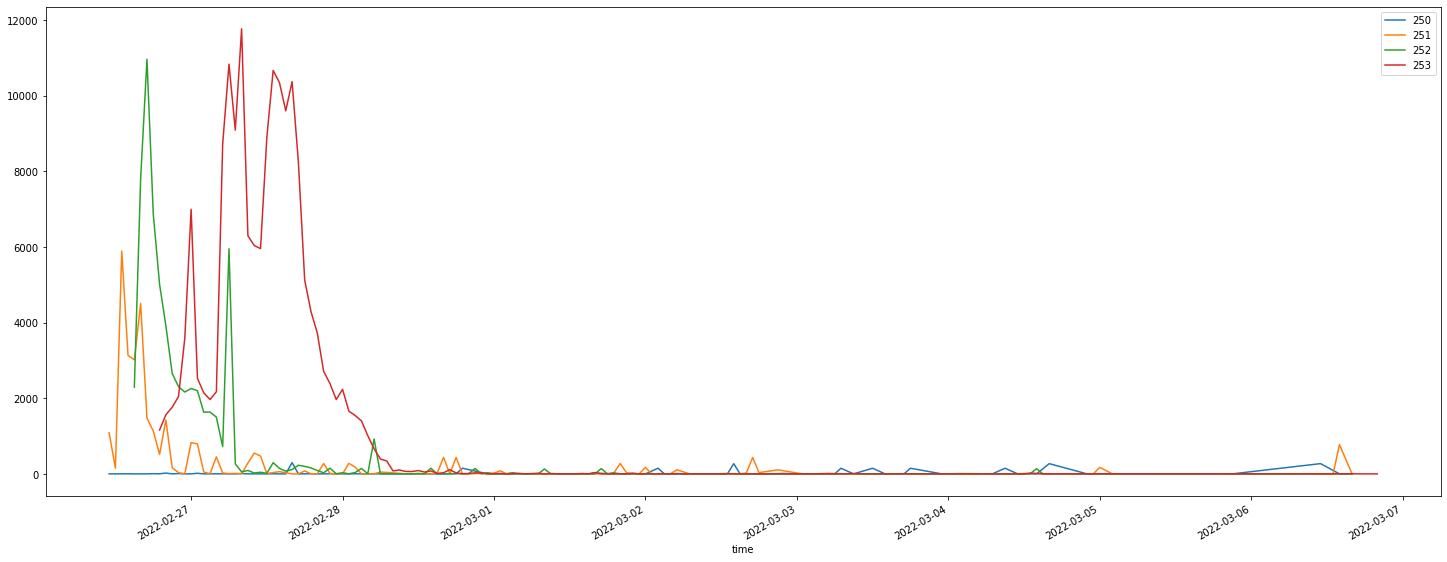

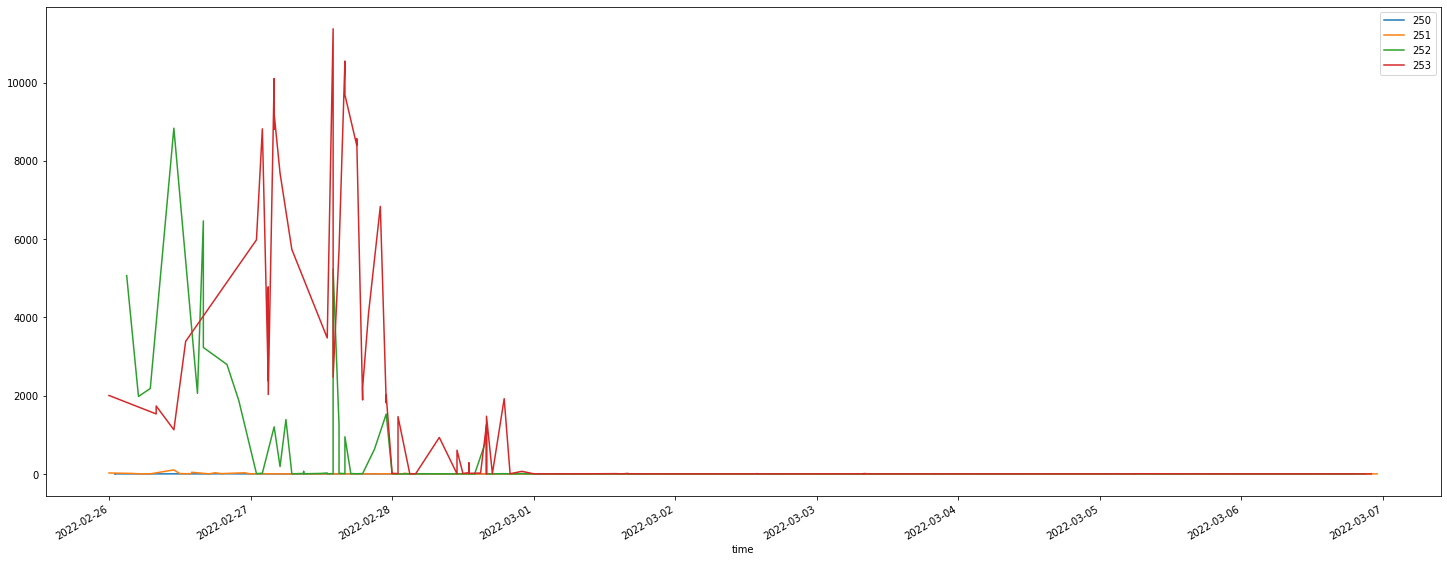

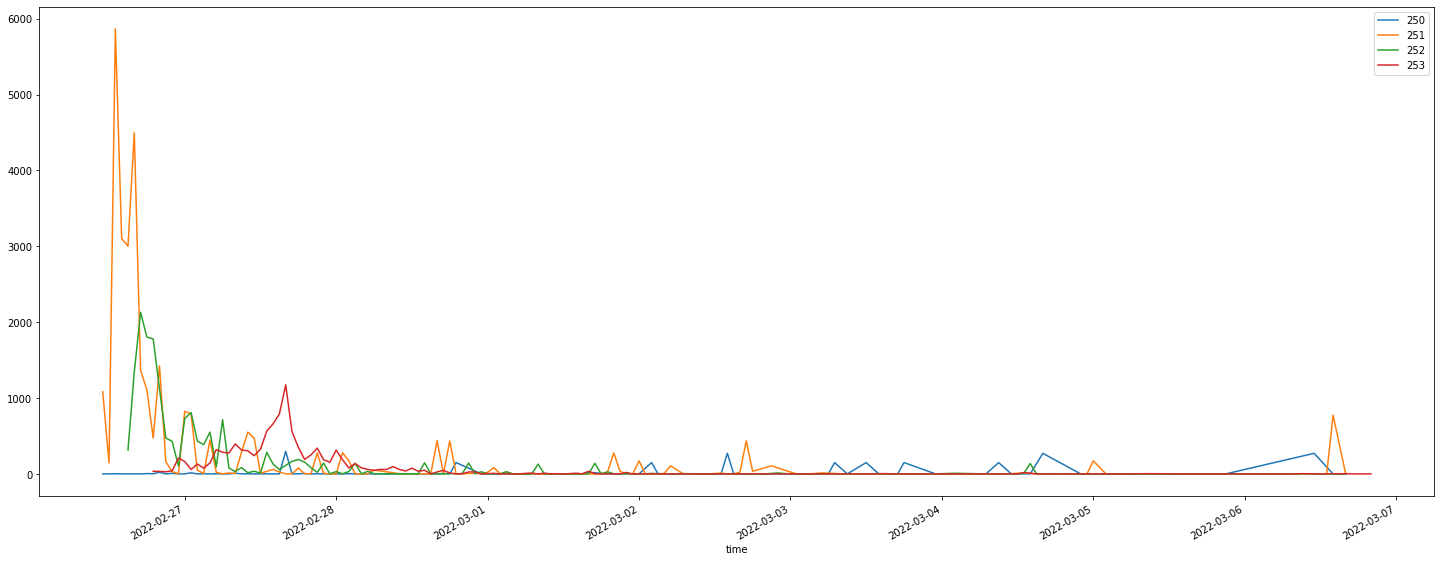

In [151]:
def show_plot(df, metric):
    fig, ax = plt.subplots(figsize=(25,10))
    
    for wordle in range(250,254):
    
        # time_df.groupby(by=['date_tweeted', 'hour_tweeted']).sum('count').plot(kind='line', y='count', ax=ax);
        df[df["wordle"]==wordle].plot(
            kind='line',
            x='time',
            y=metric, 
            ax=ax, 
            label=f"{wordle}",
            );

show_plot(time_df, "count")
show_plot(engagement_df, "total_engagement")
show_plot(favorite_df, "total_favorites")
show_plot(retweet_df, "total_retweets")